# Análise das stacks focais de parasitologia

**Objetivos**
* Levantamento de medidas de avaliação da qualidade de imagens (IQA) de microscopia
* Identificação de posição-ótima do eixo Z para foco em lâminas de parasitologia

# Análise das novas stacks focais


## Resultados

### Comparativo entre métricas de IQA
#### Comparar resultado e runtime

Os resultados por runtime mostram que o método Variance of Laplacian é o mais rápido dentre as 6 métricas, com tempo médio de 2.85 segundos por stack focal. Em seguida, os métodos RingDiff e JpegSize acompanham em segundo e terceiro lugar em velocidade, ambos com média de 3.21 segundos por stack focal. Já o método FastFourier tem tempo médio de 19.42 segundos por stack focal, e o método BRISQUE, 30.48 segundos. Em último, o método Sharpness surge em último lugar, com tempo médio de 88.12 segundos por stack focal.

Para quantificar o resultado de escolha de imagem como imagem focal, foi calculada a métrica AFF (Away From Focus) a partir da imagem com foco real definido manualmente. As métricas mais bem pontuadas nesse quesito foram a Sharpness, com erro médio quadrado de 0.25, seguida de FastFourier e JpegSize, ambas com MSE de 0.375. RingDiff e Laplacian tiveram MSE de 162.25 e BRISQUE, de 462.375.

### Comparativo entre stacks
#### Distribuição das pontuações nas métricas de IQA

Com a distribuição das pontuações de cada imagem da stack focal foi possível perceber uma forma unimodal na curva de foco. O ponto focal, em todas as 8 stacks foi encontrado entre o valor Z de 13.2 e 13.4.

Em nota, é possível que esse resultado se altere em cada equipamento e em cada tipo de amostra, sendo necessário identificar a posição real do eixo Z do dispositivo em que os pontos focais se concentrem.

## Discussão 

Em conclusão, foi identificada a possibilidade de definir um alcance de leitura para busca do foco perfeito previamente para cada equipamento e cada tipo de amostra diferente. Isso reduziria consideravelmente o tempo e processamento necessários para identificação do foco correto, durante o autofoco.

Na comparação entre métodos de avaliação da qualidade da imagem, foi observado que o método Sharpness obteve o maior número de acertos de imagens com foco correto. Porém existe um tradeoff importante de tempo de processamento e resultado. Sharpness leva 27 vezes mais tempo para processar as imagens em relação a métodos quase tão bem sucedidos, como JpegSize e, 4.53 vezes mais tempo do que o FastFourier, ambos métodos com erro médio quadrado de 0.375.



In [42]:
# Iniciamos importando todas as bibliotecas necessárias para rodar as análises
# As medidas de IQA foram definidas em arquivos distintos, sendo necessário também importá-las.

import sys
import os
from sharpness import get_sharpness
from laplacian import variance_of_laplacian
from gabs import ringDiff, jpegSize, fastFourier
from brisque import brisque_score
# from preprocess import preprocess_img
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

# Aqui definimos mais duas funções que serão importantes para avaliação das imagens
# O pré-tratamento é especificamente necessário para essas stacks focais, onde as imagens originais
# contém elementos da janela do navegador

def preprocess_img(image):
    img = cv2.imread(image,1)
    cropped_img = img[102:620, 57:1400]
    return cropped_img

# Aqui definimos a função para cálculo do erro quadrado médio.

def MSE(y_true, y_pred):
    MSE = np.square(np.subtract(y_true,y_pred)).mean()
    return MSE

# BASE_DIR = 'data/'
# stacks240 = os.path.join(BASE_DIR, 'stacks240/')
# stacks160 = os.path.join(BASE_DIR, 'stacks160/')


# Vamos utilizar um diretório base onde se encontrarão os arquivos de imagem das stacks focais.

BASE_DIR = 'data/Novos/'
stacks40x = os.path.join(BASE_DIR, '40')
stacks10x = os.path.join(BASE_DIR, '10')

# real_focus_dict = {'stack-2': '01560279863809.jpg',
#     'stack-3': '01560279977204.jpg', 'stack-4': '01560280090599.jpg',
#     'stack-5': '01560280206413.jpg', 'stack-7': '01560270248419.jpg',
#     'stack-8': '01560270484974.jpg', 'stack-9': '01560270628081.jpg',
#     'stack-10': '01560270867665.jpg', 'stack-13': '01560271096589.jpg',
#     'stack-14': '01560271168130.jpg', 'stack-16': '01560271326730.jpg',
#     'stack-17': '01560271407288.jpg', 'stack-20': '01560271641218.jpg',
#     'stack-21': '01560271717496.jpg', 'stack-22': '01560271790317.jpg',
#     'stack-23': '01560271870737.jpg', 'stack-24': '01560271949372.jpg',
#     'stack-25': '01560272030405.jpg'}


# Criamos um dicionário para cada uma das medidas de IQA

measurements = dict()
measurements['FastFourier'] = fastFourier
measurements['Laplacian'] = variance_of_laplacian
measurements['RingDiff'] = ringDiff
measurements['JpegSize'] = jpegSize
measurements['Sharpness'] = get_sharpness
measurements['BRISQUE'] = brisque_score

# MEASUREMENT = 'RingDiff'


# Aqui nós importamos os resultados que já foram calculados em uma outra sessão

import pickle

with open('all_stacks_40.pickle', 'rb') as handle:
    all_stacks_40 = pickle.load(handle)

with open('all_stacks_10.pickle', 'rb') as handle:
    all_stacks_10 = pickle.load(handle)

with open('chosen_focuses.pickle', 'rb') as handle:
    chosen_focuses = pickle.load(handle)

### Comparação entre medidas de IQA em relação ao ponto focal

In [80]:
all_stacks_40 = dict()
for folder in os.listdir(stacks40x):
    all_measurements = dict()
    for measurement in measurements.keys():        

        wk_dir = os.path.join(stacks40x, folder)
    #     if folder in real_focus_dict.keys():
    #         real_focus = os.path.join(wk_dir, real_focus_dict[folder])

        img_files = []
        for img_file_name in os.listdir(wk_dir):
            img_file = os.path.join(wk_dir, img_file_name)
            img_files.append(img_file)
        img_files = sorted(img_files)

        res = dict()
        for i in range(len(img_files)):
            res[i] = 0

        print('Running bruteforce algorithm in {} with {} as measurement.'
        .format(folder, measurement))

        count = 0
        zero_percent = True
        twenty_five_percent = True
        fifty_percent = True
        seventy_five_percent = True

        print("Calculating...")
        for img in img_files:
            count += 1
    #             preprocessed_img = preprocess_img(img)

            cropped_img = preprocess_img(img)
            res[count] = measurements[measurement](cropped_img)
            #sorted_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
    #         loading = count / len(img_files)

    #         if loading < 0.25 and zero_percent:
    #             print("0%...")
    #             zero_percent = False

    #         elif loading >= 0.25 and twenty_five_percent:
    #             print("25%...")
    #             twenty_five_percent = False

    #         elif loading >= 0.50 and fifty_percent:
    #             print("50%...")
    #             fifty_percent = False

    #         elif loading >= 0.75 and seventy_five_percent:
    #             print("75%...")
    #             seventy_five_percent = False

        #start_position = img_files.index(real_focus)

    #         score2 = sorted_dict[real_focus]

    #         position = list(sorted_dict.keys()).index(real_focus)
    #         print("The correct focus is image {} in {} position, with a score of {}."
    #         .format(real_focus, position, score2))
    #         print("The image is in the {}% percentile of the focal stack".format(
    #             start_position/len(res) * 100
    #         ))
        all_measurements[measurement] = res
    
        all_stacks_40[folder] = all_measurements

Running bruteforce algorithm in Lâmina 1 - Stack 2 - 40x with FastFourier as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 40x with Laplacian as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 40x with RingDiff as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 40x with JpegSize as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 40x with Sharpness as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 40x with BRISQUE as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 1 - 40X with FastFourier as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 1 - 40X with Laplacian as measurement.
Calculating...


KeyboardInterrupt: 

In [5]:
all_stacks_10 = dict()
for folder in os.listdir(stacks10x):
    all_measurements = dict()
    for measurement in measurements.keys():        

        wk_dir = os.path.join(stacks10x, folder)
    #     if folder in real_focus_dict.keys():
    #         real_focus = os.path.join(wk_dir, real_focus_dict[folder])

        img_files = []
        for img_file_name in os.listdir(wk_dir):
            img_file = os.path.join(wk_dir, img_file_name)
            img_files.append(img_file)
        img_files = sorted(img_files)

        res = dict()
        for i in range(len(img_files)):
            res[i] = 0

        print('Running bruteforce algorithm in {} with {} as measurement.'
        .format(folder, measurement))

        count = 0
        zero_percent = True
        twenty_five_percent = True
        fifty_percent = True
        seventy_five_percent = True

        print("Calculating...")
        for img in img_files:
            count += 1
    #             preprocessed_img = preprocess_img(img)

            cropped_img = preprocess_img(img)
            res[count] = measurements[measurement](cropped_img)
            #sorted_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
    #         loading = count / len(img_files)

    #         if loading < 0.25 and zero_percent:
    #             print("0%...")
    #             zero_percent = False

    #         elif loading >= 0.25 and twenty_five_percent:
    #             print("25%...")
    #             twenty_five_percent = False

    #         elif loading >= 0.50 and fifty_percent:
    #             print("50%...")
    #             fifty_percent = False

    #         elif loading >= 0.75 and seventy_five_percent:
    #             print("75%...")
    #             seventy_five_percent = False

        #start_position = img_files.index(real_focus)

    #         score2 = sorted_dict[real_focus]

    #         position = list(sorted_dict.keys()).index(real_focus)
    #         print("The correct focus is image {} in {} position, with a score of {}."
    #         .format(real_focus, position, score2))
    #         print("The image is in the {}% percentile of the focal stack".format(
    #             start_position/len(res) * 100
    #         ))
        all_measurements[measurement] = res
    
        all_stacks_10[folder] = all_measurements

Running bruteforce algorithm in Lâmina 2 - Stack 1 - 10x with FastFourier as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 2 - Stack 1 - 10x with Laplacian as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 2 - Stack 1 - 10x with RingDiff as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 2 - Stack 1 - 10x with JpegSize as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 2 - Stack 1 - 10x with Sharpness as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 2 - Stack 1 - 10x with BRISQUE as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 10x with FastFourier as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 10x with Laplacian as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 10x with RingDiff as measurement.
Calculating...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 10x with JpegSize as 

In [12]:
all_stacks_40.keys()

dict_keys(['Lâmina 1 - Stack 2 - 40x', 'Lâmina 1 - Stack 1 - 40X', 'Lâmina 2 - Stack 2 - 40x', 'Lâmina 2 - Stack 1 - 40x'])

<ipython-input-13-e10a9c232d9f>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))
<ipython-input-13-e10a9c232d9f>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))
<ipython-input-13-e10a9c232d9f>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))
<ipython-input-13-e10a9c232d9f>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_40.applymap(lambda x: np.log(x/10))


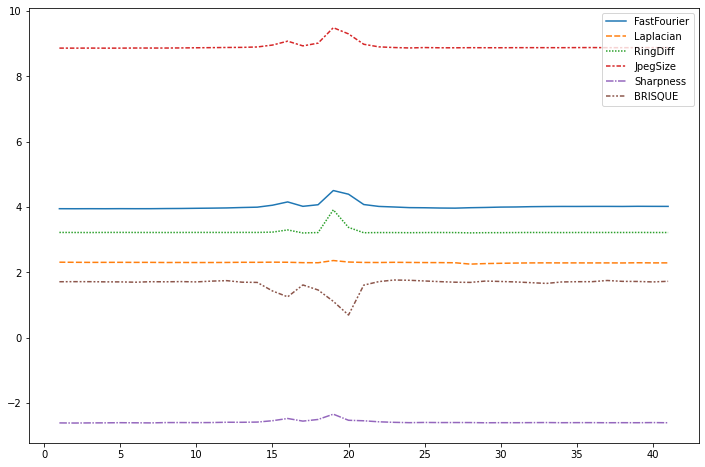

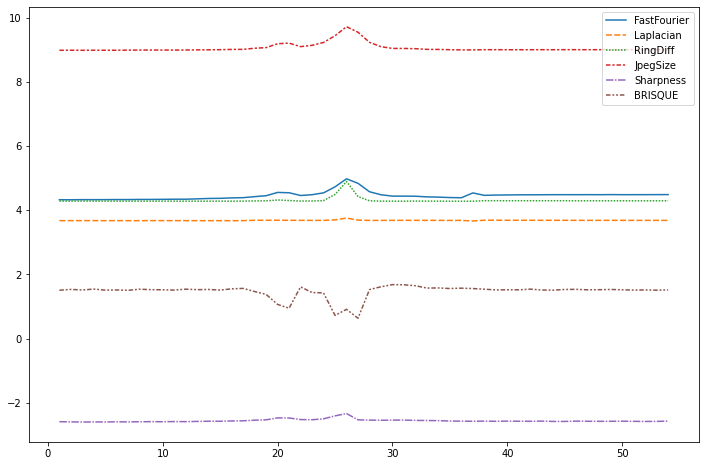

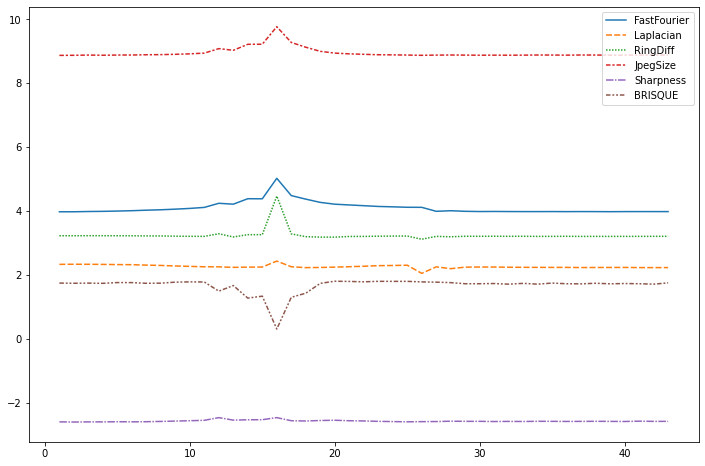

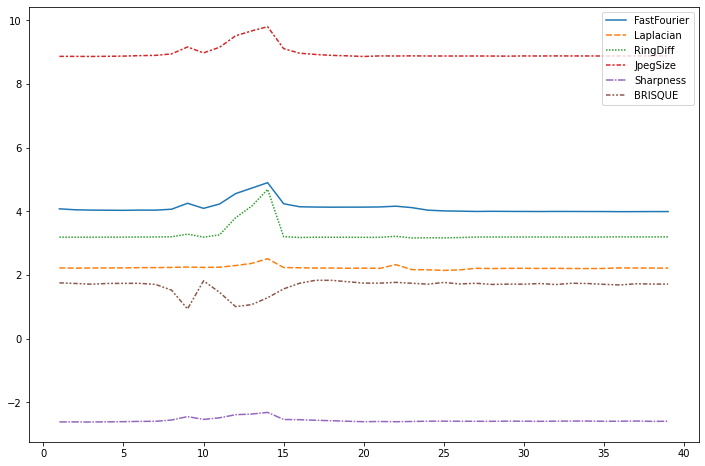

In [13]:
%matplotlib inline
for stack in all_stacks_40.keys():
    df_40 = pd.DataFrame.from_dict(all_stacks_40[stack])
    transform = df_40.applymap(lambda x: np.log(x/10))
    # test.head()
    plt.figure(figsize=(12, 8))
    sns.lineplot(data = transform)
    plt.savefig('Measurement_Comparison_{}.png'.format(stack))

<ipython-input-14-bcb1b57a7e9d>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_10.applymap(lambda x: np.log(x/10))
<ipython-input-14-bcb1b57a7e9d>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_10.applymap(lambda x: np.log(x/10))
<ipython-input-14-bcb1b57a7e9d>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_10.applymap(lambda x: np.log(x/10))
<ipython-input-14-bcb1b57a7e9d>:4: RuntimeWarning: divide by zero encountered in log
  transform = df_10.applymap(lambda x: np.log(x/10))


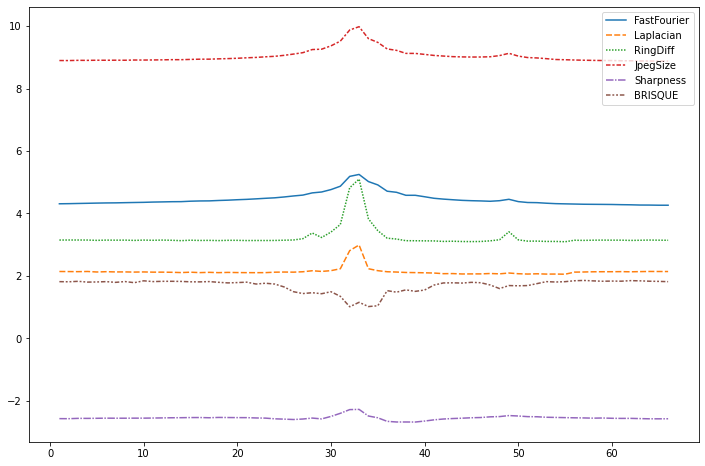

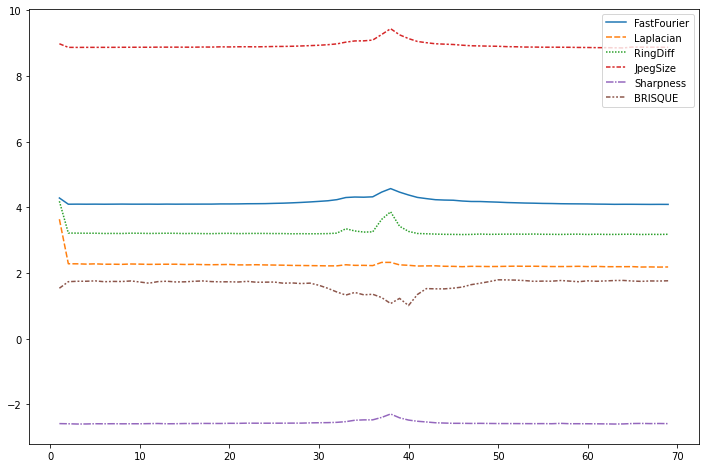

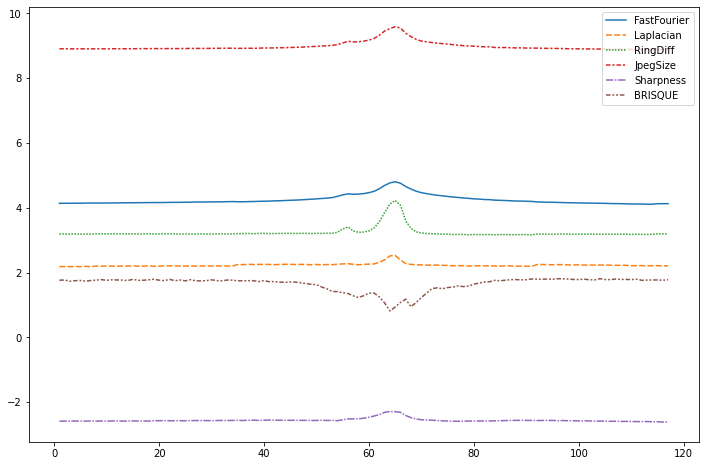

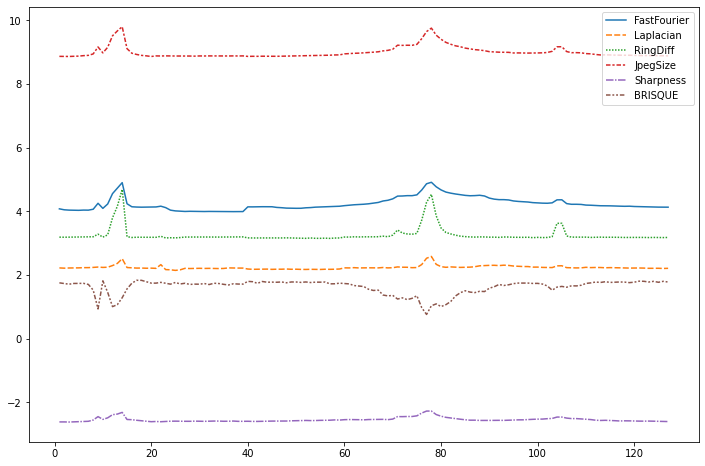

In [14]:
%matplotlib inline
for stack in all_stacks_10.keys():
    df_10 = pd.DataFrame.from_dict(all_stacks_10[stack])
    transform = df_10.applymap(lambda x: np.log(x/10))
    # test.head()
    plt.figure(figsize=(12, 8))
    sns.lineplot(data = transform)
    plt.savefig('Measurement_Comparison_{}.png'.format(stack))

### Comparação entre os valores ótimos de eixo Z para foco nas imagens de microscopia de parasitologia

In [2]:
### Extraindo manualmente dados do eixo Z
## Os arquivos da stacks focais não contém metadados para extração automática dos valores do eixo Z.
## Dessa forma, foi necessário extrair manualmente, de cada imagem, o valor do eixo Z.

# Stacks 10x

stack_10_1_1 = []
for i in np.arange(12.00, 14.02, 0.02):
    stack_10_1_1.append(round(i,2))

stack_10_1_1_list =  [14.02, 14.04, 14.08, 14.10, 14.14, 14.18,
                      14.22, 14.26, 14.28, 14.32, 14.36, 14.40,
                      14.44, 14.48]

stack_10_1_1.remove(13.02)

for i in stack_10_1_1_list:
    stack_10_1_1.append(i)
# print(stack_1_1)

stack_10_1_2 = [
    12.00, 12.02, 12.04, 12.06, 12.10, 12.14, 12.18, 12.22, 12.26, 12.30, 12.34,
    12.38, 12.42, 12.46, 12.50, 12.54, 12.58, 12.62,  12.66, 12.70, 12.74, 12.76,
    12.80, 12.84, 12.88, 12.92, 12.96, 13.00, 13.04, 13.08, 13.12, 13.16, 13.20,
    13.24, 13.28, 13.30, 13.34, 13.36, 13.38, 13.42, 13.46, 13.50, 13.52, 13.54,
    13.56, 13.60, 13.64, 13.68, 13.72, 13.76, 13.80, 13.84, 13.88, 13.92, 13.96,
    14.00, 14.04, 14.08, 14.12, 14.16, 14.20, 14.24, 14.28, 14.32, 14.36, 14.40,
    14.44, 14.48, 14.50
]

stack_10_2_1 = [
    12.00, 12.02, 12.06, 12.10, 12.14, 12.16, 12.18, 12.22, 12.26, 12.30, 12.34, 12.38,
    12.42, 12.46, 12.50, 12.54, 12.58, 12.62, 12.66, 12.70, 12.74, 12.78, 12.82, 12.86,
    12.90, 12.94, 12.96, 13.00, 13.04, 13.08, 13.14, 13.18, 13.20, 13.24, 13.28, 13.34,
    13.38, 13.42, 13.44, 13.48, 13.52, 13.56, 13.60, 13.64, 13.68, 13.72, 13.76, 13.80,
    13.82, 13.86, 13.90, 13.94, 13.98, 14.02, 14.06, 14.10, 14.14, 14.18, 14.20, 14.24,
    14.28, 14.32, 14.36, 14.40, 14.44, 14.48
]

stack_10_2_2 = []
for i in np.arange(12.00, 12.80, 0.04):
    stack_10_2_2.append(round(i,2))

stack_10_2_2_list = [
    12.80, 12.82, 12.84, 12.86, 12.88, 12.90, 12.92, 12.96, 12.98, 13.00, 13.02, 13.06,
    13.08, 13.10, 13.10, 13.12, 13.16, 13.20, 13.24, 13.26, 13.28, 13.30, 13.32, 13.34,
    13.36, 13.38, 13.40, 13.42, 13.44, 13.46, 13.50, 13.52, 13.54, 13.56, 13.62, 13.64,
    13.66, 13.70, 13.72, 13.74, 13.76, 13.78, 13.82, 13.86, 13.86, 13.90, 13.92, 13.92,
    13.94, 13.98, 14.00, 14.04, 14.06, 14.08, 14.10, 14.14, 14.18, 14.20, 14.22, 14.26, 
    14.30, 14.34, 14.38, 14.42, 14.46, 14.48, 14.50
]

for i in stack_10_2_2_list:
    stack_10_2_2.append(i)
    
    
    
# Stacks 40x

stack_40_1_1 = [13.00]
for i in np.arange(13.01, 13.20, 0.02):
    stack_40_1_1.append(round(i,2))
    
stack_40_1_1_list = [
    13.23, 13.27, 13.31, 13.33, 13.37, 13.41, 13.43, 13.45, 13.47, 13.49, 13.53, 13.55,
    13.57, 13.59, 13.61, 13.65, 13.69, 13.71, 13.71, 13.73, 13.77, 13.81, 13.85, 13.89,
    13.93, 13.97, 14.01, 14.05, 14.09, 14.13, 14.17, 14.21, 14.25, 14.29, 14.33, 14.37,
    14.41, 14.43, 14.45, 14.47, 14.49, 14.51, 13.13
]

for i in stack_40_1_1_list:
    stack_40_1_1.append(i)
    
stack_40_1_1 = sorted(stack_40_1_1)

stack_40_1_2 = [
    13.00, 13.02, 13.06, 13.10, 13.14, 13.18, 13.22, 13.26, 13.30, 13.34, 13.38, 13.42,
    13.44, 13.48, 13.52, 13.54, 13.58, 13.62, 13.64, 13.68, 13.72, 13.76, 13.80, 13.84,
    13.88, 13.92, 13.96, 14.00, 14.04, 14.08, 14.12, 14.16, 14.20, 14.24, 14.28, 14.30,
    14.34, 14.38, 14.42, 14.46, 14.50
]

stack_40_2_1 = [
    13.00, 13.02, 13.08, 13.14, 13.18, 13.22, 13.26, 13.30, 13.34, 13.38, 13.42, 13.46,
    13.48, 13.50, 13.54, 13.58, 13.62, 13.66, 13.70, 13.74, 13.78, 13.82, 13.86, 13.90,
    13.94, 13.98, 14.02, 14.06, 14.10, 14.14, 14.18, 14.22, 14.26, 14.30, 14.34, 14.38,
    14.42, 14.46, 14.50
]

stack_40_2_2 = [
    13.00, 13.02, 13.04, 13.06, 13.10, 13.14, 13.18, 13.22, 13.26, 13.30, 13.34, 13.38,
    13.42, 13.46, 13.48, 13.52, 13.54, 13.56, 13.60, 13.64, 13.68, 13.72, 13.76, 13.80,
    13.84, 13.88, 13.92, 13.96, 14.00, 14.04, 14.08, 14.12, 14.14, 14.18, 14.22, 14.26, 
    14.28, 14.30, 14.32, 14.36, 14.40, 14.44, 14.48
]

In [7]:
print(len(stack_10_1_1))
print(len(stack_10_1_2))
print(len(stack_10_2_1))
print(len(stack_10_2_2))
print(len(stack_40_1_1))
print(len(stack_40_1_2))
print(len(stack_40_2_1))
print(len(stack_40_2_2))

114
69
66
88
54
41
39
43


In [8]:
all_stacks_40 = dict()
for folder in os.listdir(stacks40x):
    wk_dir = os.path.join(stacks40x, folder)
#     if folder in real_focus_dict.keys():
#         real_focus = os.path.join(wk_dir, real_focus_dict[folder])

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)
    
    res = dict()
#     for i in range(len(img_files)):
#         res[i] = 0

    print('Running bruteforce algorithm in {} with {} as measurement.'
    .format(folder, MEASUREMENT))

    count = 0
    zero_percent = True
    twenty_five_percent = True
    fifty_percent = True
    seventy_five_percent = True

    print("Calculating...")
    for img in img_files:
        count += 1
#             preprocessed_img = preprocess_img(img)

        cropped_img = preprocess_img(img)
        res[count] = measurements[MEASUREMENT](cropped_img)
        #sorted_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
        loading = count / len(img_files)

        if loading < 0.25 and zero_percent:
            print("0%...")
            zero_percent = False

        elif loading >= 0.25 and twenty_five_percent:
            print("25%...")
            twenty_five_percent = False

        elif loading >= 0.50 and fifty_percent:
            print("50%...")
            fifty_percent = False

        elif loading >= 0.75 and seventy_five_percent:
            print("75%...")
            seventy_five_percent = False

    #start_position = img_files.index(real_focus)

#         score2 = sorted_dict[real_focus]

#         position = list(sorted_dict.keys()).index(real_focus)
#         print("The correct focus is image {} in {} position, with a score of {}."
#         .format(real_focus, position, score2))
#         print("The image is in the {}% percentile of the focal stack".format(
#             start_position/len(res) * 100
#         ))
    all_stacks_40[folder] = res

Running bruteforce algorithm in Lâmina 1 - Stack 2 - 40x with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Lâmina 1 - Stack 1 - 40X with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Lâmina 2 - Stack 2 - 40x with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Lâmina 2 - Stack 1 - 40x with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...


In [9]:
# df_40_1_1 = pd.DataFrame.from_dict(all_stacks_40['Lâmina 1 - Stack 1 - 40X'], orient = 'index')
# df_40_1_1['z_values'] = stack_40_1_1
# df_40_1_1.columns = ['L1S1', 'z_values']

# df_40_1_2 = pd.DataFrame.from_dict(all_stacks_40['Lâmina 1 - Stack 2 - 40x'], orient = 'index')
# df_40_1_2['z_values'] = stack_40_1_2
# df_40_1_2.columns = ['L1S2', 'z_values']

# df_40_2_1 = pd.DataFrame.from_dict(all_stacks_40['Lâmina 2 - Stack 1 - 40x'], orient = 'index')
# df_40_2_1['z_values'] = stack_40_2_1
# df_40_2_1.columns = ['L2S1', 'z_values']

# df_40_2_2 = pd.DataFrame.from_dict(all_stacks_40['Lâmina 2 - Stack 2 - 40x'], orient = 'index')
# df_40_2_2['z_values'] = stack_40_2_2
# df_40_2_2.columns = ['L2S2', 'z_values']

df_40_1_1 = pd.DataFrame.from_dict(all_stacks_40['Lâmina 1 - Stack 1 - 40X'], orient = 'index')
df_40_1_1.index = stack_40_1_1
df_40_1_1.columns = ['L1S1']

df_40_1_2 = pd.DataFrame.from_dict(all_stacks_40['Lâmina 1 - Stack 2 - 40x'], orient = 'index')
df_40_1_2.index = stack_40_1_2
df_40_1_2.columns = ['L1S2']

df_40_2_1 = pd.DataFrame.from_dict(all_stacks_40['Lâmina 2 - Stack 1 - 40x'], orient = 'index')
df_40_2_1.index = stack_40_2_1
df_40_2_1.columns = ['L2S1']

df_40_2_2 = pd.DataFrame.from_dict(all_stacks_40['Lâmina 2 - Stack 2 - 40x'], orient = 'index')
df_40_2_2.index = stack_40_2_2
df_40_2_2.columns = ['L2S2']



# df_40 = pd.DataFrame.from_dict(all_stacks_40, orient='index')
# transform = df_40.applymap(lambda x: np.log(x/10))
# # test.head()
# # %matplotlib inline
# # plt.figure(figsize=(12, 8))
# # sns.lineplot(data = transform)
# # #plt.savefig('Novas_Stacks_40x_Laplacian.png')

In [10]:
# df_40 = df_40_1_1.merge(df_40_1_2, how='outer', on = 'z_values')
# df_40 = df_40.merge(df_40_2_1, how='outer', on = 'z_values')
# df_40 = df_40.merge(df_40_2_2, how='outer', on = 'z_values')

df_40 = df_40_1_1.merge(df_40_1_2, how='outer', left_index= True, right_index = True)
df_40 = df_40.merge(df_40_2_1, how='outer', left_index= True, right_index = True)
df_40 = df_40.merge(df_40_2_2, how='outer', left_index= True, right_index = True)

# df_40 = df_40.sort_values('z_values')
# df_40.reset_index(inplace=True)
# df_40.drop('index', axis = 1, inplace=True)
df_40

L1S1        L1S2        L2S1        L2S2
13.00  725.943450  251.563415  242.930561  251.025884
13.01  725.141887         NaN         NaN         NaN
13.02         NaN  251.167494  242.312276  250.905973
13.03  726.419398         NaN         NaN         NaN
13.04         NaN         NaN         NaN  251.323913
...           ...         ...         ...         ...
14.47  731.984055         NaN         NaN         NaN
14.48         NaN         NaN         NaN  246.311448
14.49  732.541347         NaN         NaN         NaN
14.50         NaN  250.881865  244.831404         NaN
14.51  732.166810         NaN         NaN         NaN

[121 rows x 4 columns]

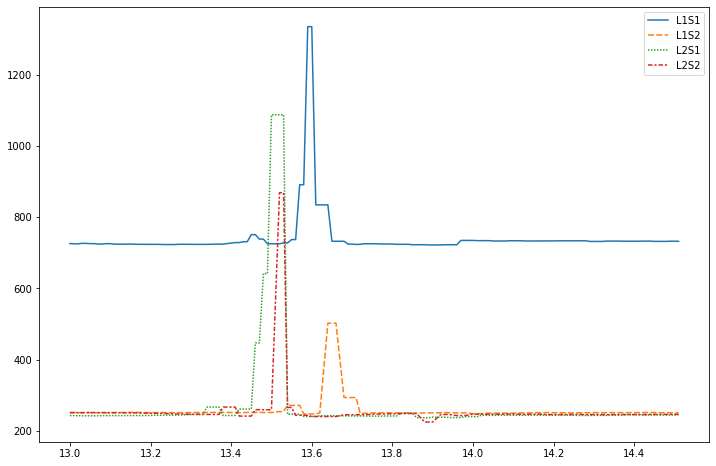

In [11]:
%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.lineplot(data=df_40.fillna(method='ffill'))
# plt.show()
# plt.savefig('z_value_40x.png')

In [12]:
all_stacks_10 = dict()
for folder in os.listdir(stacks10x):
    wk_dir = os.path.join(stacks10x, folder)
#     if folder in real_focus_dict.keys():
#         real_focus = os.path.join(wk_dir, real_focus_dict[folder])

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)
    
    res = dict()
#     for i in range(len(img_files)):
#         res[i] = 0

    print('Running bruteforce algorithm in {} with {} as measurement.'
    .format(folder, MEASUREMENT))

    count = 0
    zero_percent = True
    twenty_five_percent = True
    fifty_percent = True
    seventy_five_percent = True

    print("Calculating...")
    for img in img_files:
        count += 1
#             preprocessed_img = preprocess_img(img)

        cropped_img = preprocess_img(img)
        res[count] = measurements[MEASUREMENT](cropped_img)
        #sorted_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
        loading = count / len(img_files)

        if loading < 0.25 and zero_percent:
            print("0%...")
            zero_percent = False

        elif loading >= 0.25 and twenty_five_percent:
            print("25%...")
            twenty_five_percent = False

        elif loading >= 0.50 and fifty_percent:
            print("50%...")
            fifty_percent = False

        elif loading >= 0.75 and seventy_five_percent:
            print("75%...")
            seventy_five_percent = False

    #start_position = img_files.index(real_focus)

#         score2 = sorted_dict[real_focus]

#         position = list(sorted_dict.keys()).index(real_focus)
#         print("The correct focus is image {} in {} position, with a score of {}."
#         .format(real_focus, position, score2))
#         print("The image is in the {}% percentile of the focal stack".format(
#             start_position/len(res) * 100
#         ))
    all_stacks_10[folder] = res

Running bruteforce algorithm in Lâmina 2 - Stack 1 - 10x with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Lâmina 1 - Stack 2 - 10x with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Lâmina 1 - Stack 1 - 10x with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...
Running bruteforce algorithm in Lâmina 2 - Stack 2 - 10x with RingDiff as measurement.
Calculating...
0%...
25%...
50%...
75%...


In [13]:
all_stacks_10.keys()

dict_keys(['Lâmina 2 - Stack 1 - 10x', 'Lâmina 1 - Stack 2 - 10x', 'Lâmina 1 - Stack 1 - 10x', 'Lâmina 2 - Stack 2 - 10x'])

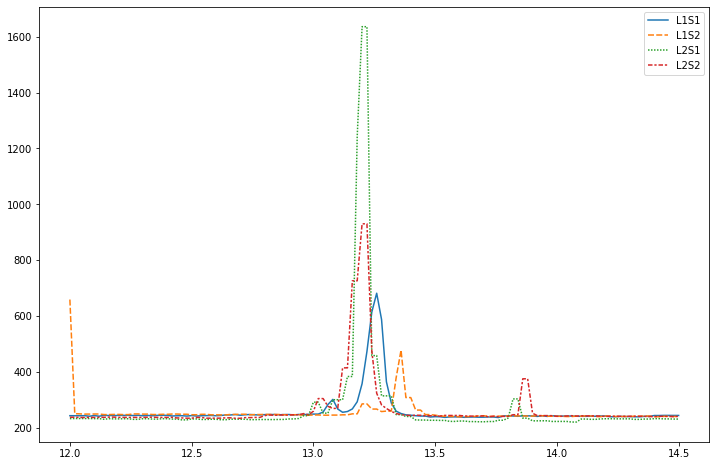

In [14]:
df_10_1_1 = pd.DataFrame.from_dict(all_stacks_10['Lâmina 1 - Stack 1 - 10x'], orient = 'index')
df_10_1_1.index = stack_10_1_1
df_10_1_1.columns = ['L1S1']

df_10_1_2 = pd.DataFrame.from_dict(all_stacks_10['Lâmina 1 - Stack 2 - 10x'], orient = 'index')
df_10_1_2.index = stack_10_1_2
df_10_1_2.columns = ['L1S2']

df_10_2_1 = pd.DataFrame.from_dict(all_stacks_10['Lâmina 2 - Stack 1 - 10x'], orient = 'index')
df_10_2_1.index = stack_10_2_1
df_10_2_1.columns = ['L2S1']

df_10_2_2 = pd.DataFrame.from_dict(all_stacks_10['Lâmina 2 - Stack 2 - 10x'], orient = 'index')
df_10_2_2.index = stack_10_2_2
df_10_2_2.columns = ['L2S2']

df_10 = df_10_1_1.merge(df_10_1_2, how='outer', left_index= True, right_index = True)
df_10 = df_10.merge(df_10_2_1, how='outer', left_index= True, right_index = True)
df_10 = df_10.merge(df_10_2_2, how='outer', left_index= True, right_index = True)

%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.lineplot(data=df_10.fillna(method='ffill'))
# plt.show()
# plt.savefig('z_value_10x.png')

### Avaliando os métodos de IQA em relação as imagens elegidas como melhor foco.
#### Comparando os runtimes de cada método.

In [5]:
########### Showing chosen images
chosen_focuses = dict()
all_stacks_40 = dict()
runtimes = dict()
for folder in os.listdir(stacks40x):
    wk_dir = os.path.join(stacks40x, folder)

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)
    
    res = dict()

    for MEASUREMENT in measurements.keys():
        print("Measuring {} with {}".format(folder, MEASUREMENT))
        start_time = time.time()
        count = 0
        for img in img_files:
            count += 1

            
            cropped_img = preprocess_img(img)
            
            res[img] = measurements[MEASUREMENT](cropped_img)
        chosen_focus = max(res, key=res.get)
            
#             res[count] = measurements[MEASUREMENT](cropped_img)

#         chosen_focus = img_files[max(res, key=res.get)]

        key = "{}_{}".format(folder, MEASUREMENT)
        chosen_focuses[key] = chosen_focus
        
        all_stacks_40[key] = res
        end_time = time.time()
        
        runtime = end_time - start_time
        
        runtimes[key] = runtime
        
        print("Found the best focused image. \n Total runtime: {}".format(runtime))
    
all_stacks_10 = dict()
for folder in os.listdir(stacks10x):
    wk_dir = os.path.join(stacks10x, folder)

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)
    
    res = dict()

    for MEASUREMENT in measurements.keys():
        print("Measuring {} with {}".format(folder, MEASUREMENT))
        start_time = time.time()
        count = 0
        for img in img_files:
            count += 1
            cropped_img = preprocess_img(img)
            
            res[img] = measurements[MEASUREMENT](cropped_img)
        chosen_focus = max(res, key=res.get)
            
#             res[count] = measurements[MEASUREMENT](cropped_img)

#         chosen_focus = img_files[max(res, key=res.get)]
        
        key = "{}_{}".format(folder, MEASUREMENT)
        chosen_focuses[key] = chosen_focus
        all_stacks_10[key] = res
        
        end_time = time.time()
        
        runtime = end_time - start_time
        
        runtimes[key] = runtime
        
        print("Found the best focused image. \n Total runtime: {}".format(runtime))

Measuring Lâmina 1 - Stack 2 - 40x with FastFourier
Found the best focused image. 
 Total runtime: 13.453179359436035
Measuring Lâmina 1 - Stack 2 - 40x with Laplacian
Found the best focused image. 
 Total runtime: 1.8240797519683838
Measuring Lâmina 1 - Stack 2 - 40x with RingDiff
Found the best focused image. 
 Total runtime: 2.079749584197998
Measuring Lâmina 1 - Stack 2 - 40x with JpegSize
Found the best focused image. 
 Total runtime: 2.055128335952759
Measuring Lâmina 1 - Stack 2 - 40x with Sharpness
Found the best focused image. 
 Total runtime: 53.93339943885803
Measuring Lâmina 1 - Stack 2 - 40x with BRISQUE
Found the best focused image. 
 Total runtime: 20.320353746414185
Measuring Lâmina 1 - Stack 1 - 40X with FastFourier
Found the best focused image. 
 Total runtime: 16.246416330337524
Measuring Lâmina 1 - Stack 1 - 40X with Laplacian
Found the best focused image. 
 Total runtime: 2.63265323638916
Measuring Lâmina 1 - Stack 1 - 40X with RingDiff
Found the best focused image

In [6]:
with open('all_stacks_40.pickle', 'wb') as handle:
    pickle.dump(all_stacks_40, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_stacks_10.pickle', 'wb') as handle:
    pickle.dump(all_stacks_10, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('chosen_focuses.pickle', 'wb') as handle:
    pickle.dump(chosen_focuses, handle, protocol=pickle.HIGHEST_PROTOCOL)

Showing chosen images for Lâmina 1 - Stack 1 - 10x


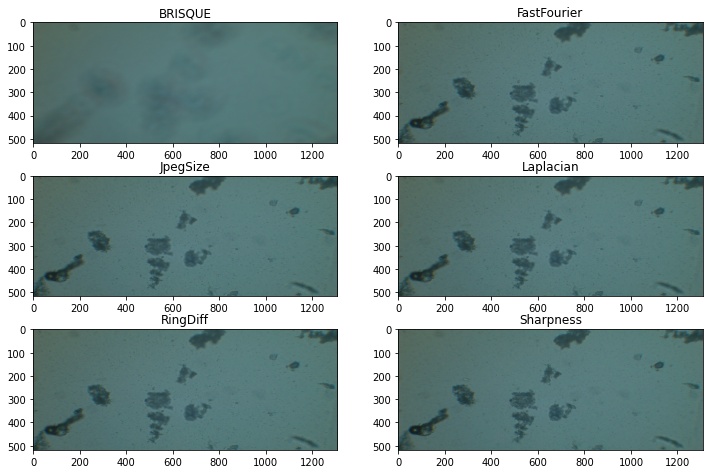

Showing chosen images for Lâmina 1 - Stack 1 - 40X


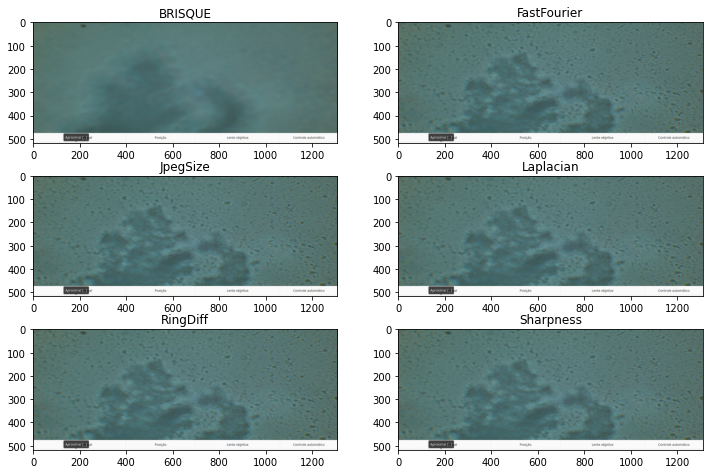

Showing chosen images for Lâmina 1 - Stack 2 - 10x


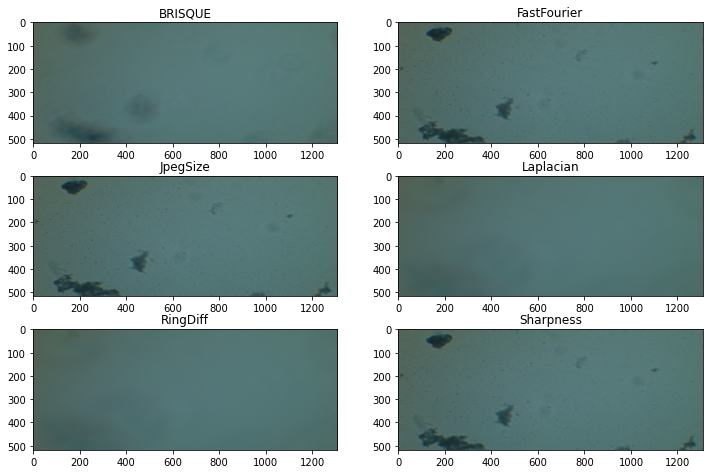

Showing chosen images for Lâmina 1 - Stack 2 - 40x


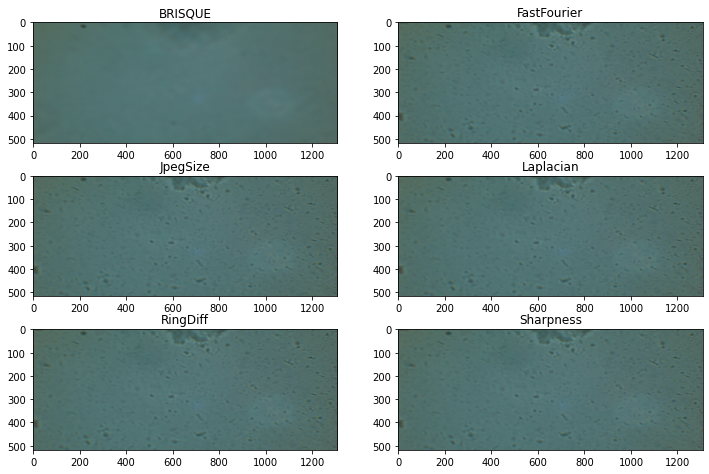

Showing chosen images for Lâmina 2 - Stack 1 - 10x


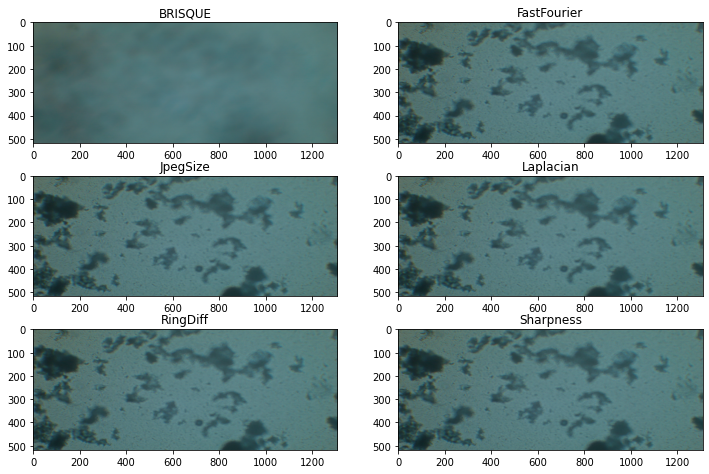

Showing chosen images for Lâmina 2 - Stack 1 - 40x


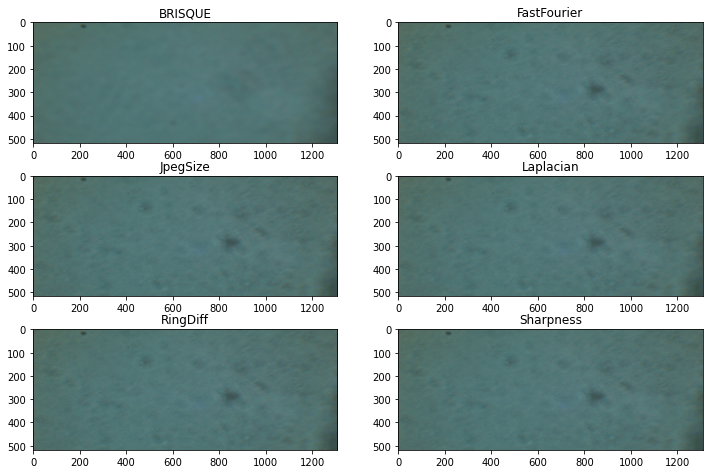

Showing chosen images for Lâmina 2 - Stack 2 - 10x


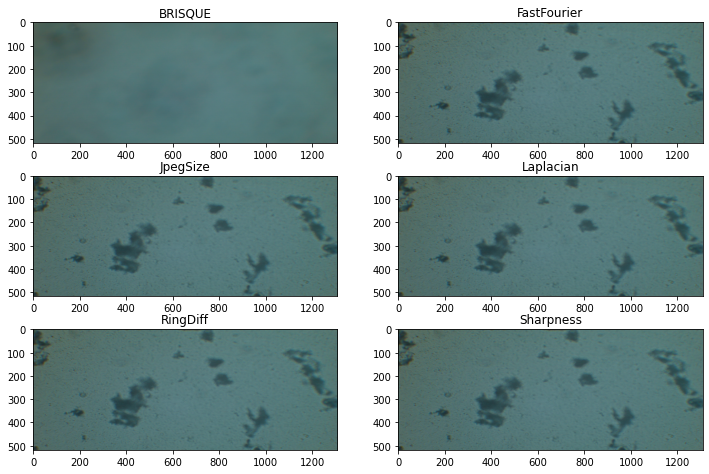

Showing chosen images for Lâmina 2 - Stack 2 - 40x


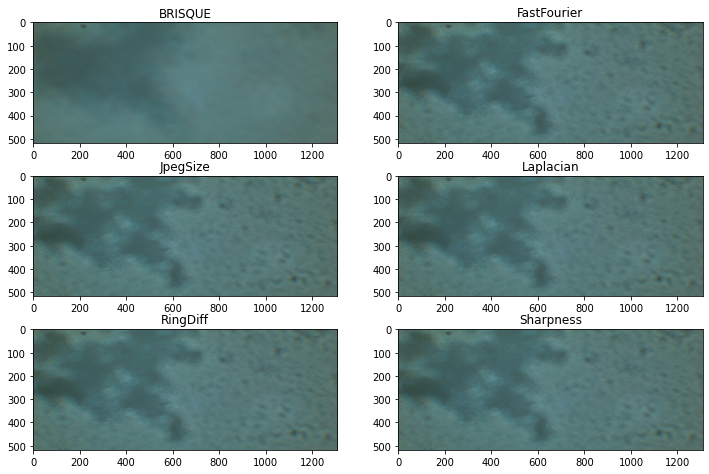

In [9]:
sorted_chosen_focuses = sorted(chosen_focuses)

for i in range(0, 48, 6):
    stack_name = ''.join(sorted_chosen_focuses[i].split("_")[:-1])
    print("Showing chosen images for {}".format(stack_name))
    
    i1 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i]])
    i2 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+1]])
    i3 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+2]])
    i4 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+3]])
    i5 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+4]])
    i6 = preprocess_img(chosen_focuses[sorted_chosen_focuses[i+5]])   

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 8))

    ax1.imshow(i1)
    ax1.set_title(str(sorted_chosen_focuses[i].split("_")[-1]))
    ax2.imshow(i2)
    ax2.set_title(str(sorted_chosen_focuses[i+1].split("_")[-1]))
    ax3.imshow(i3)
    ax3.set_title(str(sorted_chosen_focuses[i+2].split("_")[-1]))
    ax4.imshow(i4)
    ax4.set_title(str(sorted_chosen_focuses[i+3].split("_")[-1]))
    ax5.imshow(i5)
    ax5.set_title(str(sorted_chosen_focuses[i+4].split("_")[-1]))
    ax6.imshow(i6)
    ax6.set_title(str(sorted_chosen_focuses[i+5].split("_")[-1]))
    
#     plt.savefig("Chosen Images for {}".format(stack_name))
    plt.show()

In [20]:
for i in range(0, 48, 6):
    stack_name = ''.join(sorted_chosen_focuses[i].split("_")[:-1])
    print("Showing chosen images names for {}".format(stack_name))
    
    i1 = chosen_focuses[sorted_chosen_focuses[i]]
    i2 = chosen_focuses[sorted_chosen_focuses[i+1]]
    i3 = chosen_focuses[sorted_chosen_focuses[i+2]]
    i4 = chosen_focuses[sorted_chosen_focuses[i+3]]
    i5 = chosen_focuses[sorted_chosen_focuses[i+4]]
    i6 = chosen_focuses[sorted_chosen_focuses[i+5]]
    
    print(i1)
    print(i2)
    print(i3)
    print(i4)
    print(i5)
    print(i6)

Showing chosen images names for Lâmina 1 - Stack 1 - 10x
data/Novos/10/Lâmina 1 - Stack 1 - 10x/DeepinScreenshot_20200916154603.png
data/Novos/10/Lâmina 1 - Stack 1 - 10x/DeepinScreenshot_20200916153704.png
data/Novos/10/Lâmina 1 - Stack 1 - 10x/DeepinScreenshot_20200916153704.png
data/Novos/10/Lâmina 1 - Stack 1 - 10x/DeepinScreenshot_20200916153704.png
data/Novos/10/Lâmina 1 - Stack 1 - 10x/DeepinScreenshot_20200916153704.png
data/Novos/10/Lâmina 1 - Stack 1 - 10x/DeepinScreenshot_20200916153700.png
Showing chosen images names for Lâmina 1 - Stack 1 - 40X
data/Novos/40/Lâmina 1 - Stack 1 - 40X/DeepinScreenshot_20200916165204.png
data/Novos/40/Lâmina 1 - Stack 1 - 40X/DeepinScreenshot_20200916165036.png
data/Novos/40/Lâmina 1 - Stack 1 - 40X/DeepinScreenshot_20200916165036.png
data/Novos/40/Lâmina 1 - Stack 1 - 40X/DeepinScreenshot_20200916165036.png
data/Novos/40/Lâmina 1 - Stack 1 - 40X/DeepinScreenshot_20200916165036.png
data/Novos/40/Lâmina 1 - Stack 1 - 40X/DeepinScreenshot_20200

In [8]:
#### Runtimes
runtimes_brisque = dict()
runtimes_sharpness = dict()
runtimes_jpegsize = dict()
runtimes_ringdiff = dict()
runtimes_laplacian = dict()
runtimes_fastfourier = dict()

for key in runtimes.keys():
    stack = ''.join(key.split("_")[:-1])
    measurement = ''.join(key.split("_")[-1])
    
    if measurement == "BRISQUE":
        runtimes_brisque[stack] = runtimes[key]
    
    elif measurement == "Sharpness":
        runtimes_sharpness[stack] = runtimes[key]
        
#         runtimes_sharpness.append(df)

    elif measurement == "Laplacian":
        runtimes_laplacian[stack] = runtimes[key]
        
    elif measurement == "FastFourier":
        runtimes_fastfourier[stack] = runtimes[key]
        
    elif measurement == "JpegSize":
        runtimes_jpegsize[stack] = runtimes[key]
                
    elif measurement == "RingDiff":
        runtimes_ringdiff[stack] = runtimes[key]

        
runtimes_laplacian = pd.DataFrame.from_dict(runtimes_laplacian, orient = 'index')
runtimes_fastfourier = pd.DataFrame.from_dict(runtimes_fastfourier, orient = "index")
runtimes_jpegsize = pd.DataFrame.from_dict(runtimes_jpegsize, orient = "index")
runtimes_ringdiff = pd.DataFrame.from_dict(runtimes_ringdiff, orient = "index")
runtimes_sharpness = pd.DataFrame.from_dict(runtimes_sharpness, orient = "index")

runtimes_df = pd.DataFrame.from_dict(runtimes_brisque, orient = "index")

runtimes_df = runtimes_df.merge(runtimes_sharpness, how = "outer", left_index = True,
                                    right_index = True)
runtimes_df = runtimes_df.merge(runtimes_laplacian, how = "outer", left_index = True,
                               right_index = True)
runtimes_df = runtimes_df.merge(runtimes_fastfourier, how = "outer", left_index = True,
                               right_index = True)
runtimes_df = runtimes_df.merge(runtimes_jpegsize, how = "outer", left_index = True,
                               right_index = True)
runtimes_df = runtimes_df.merge(runtimes_ringdiff, how = "outer", left_index = True,
                               right_index = True)
runtimes_df.columns = [
    "BRISQUE", "Sharpness", "Laplacian", "FastFourier", "JpegSize", "RingDiff"
]

runtimes_df.sort_values("JpegSize", inplace=True)

In [9]:
runtimes_df

BRISQUE   Sharpness  Laplacian  FastFourier  \
Lâmina 2 - Stack 1 - 40x  18.992475   52.631362   1.699663    11.642191   
Lâmina 1 - Stack 2 - 40x  20.320354   53.933399   1.824080    13.453179   
Lâmina 2 - Stack 2 - 40x  20.576068   58.350891   1.859145    12.866343   
Lâmina 1 - Stack 1 - 40X  24.171976   71.688001   2.632653    16.246416   
Lâmina 2 - Stack 1 - 10x  30.875583   93.128467   2.828083    19.479825   
Lâmina 1 - Stack 2 - 10x  32.856299   94.132127   2.952735    20.802694   
Lâmina 2 - Stack 2 - 10x  42.075746  123.455047   3.856098    26.685476   
Lâmina 1 - Stack 1 - 10x  53.988021  157.680568   5.194536    34.200320   

                          JpegSize  RingDiff  
Lâmina 2 - Stack 1 - 40x  1.972484  1.921450  
Lâmina 1 - Stack 2 - 40x  2.055128  2.079750  
Lâmina 2 - Stack 2 - 40x  2.143145  2.124875  
Lâmina 1 - Stack 1 - 40X  2.655169  2.592474  
Lâmina 2 - Stack 1 - 10x  3.296634  3.251620  
Lâmina 1 - Stack 2 - 10x  3.494979  3.435508  
Lâmina 2 - Stack 2 - 10x  4.396840  4.357406  
Lâmina 1 - Stack 1 - 10x  5.692784  5.929072

In [45]:
runtimes_df.mean()

BRISQUE        30.482065
Sharpness      88.124983
Laplacian       2.855874
FastFourier    19.422056
JpegSize        3.213395
RingDiff        3.211519
dtype: float64

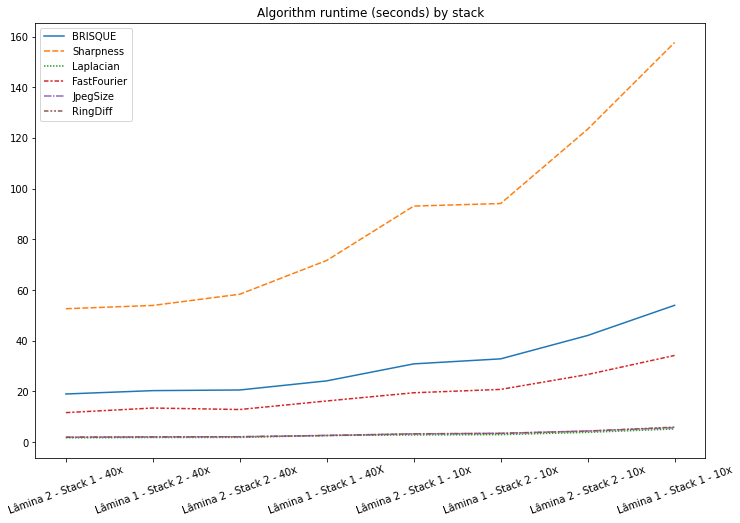

In [17]:
%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.lineplot(data=runtimes_df)
# plt.show()
plt.title("Algorithm runtime (seconds) by stack")
plt.xticks(rotation=20)
plt.savefig('runtimes_by_measurement.png')

In [19]:
#### Manual focus setup

manual_focuses = {
    "Lâmina 1 - Stack 1 - 10x": "DeepinScreenshot_20200916153653.png",
    "Lâmina 1 - Stack 2 - 10x": "DeepinScreenshot_20200916171217.png",
    "Lâmina 2 - Stack 1 - 10x": "DeepinScreenshot_20200918093627.png",
    "Lâmina 2 - Stack 2 - 10x": "DeepinScreenshot_20200918095800.png",
    "Lâmina 1 - Stack 1 - 40X": "DeepinScreenshot_20200916165033.png",
    "Lâmina 1 - Stack 2 - 40x": "DeepinScreenshot_20200916172232.png",
    "Lâmina 2 - Stack 1 - 40x": "DeepinScreenshot_20200918094313.png",
    "Lâmina 2 - Stack 2 - 40x": "DeepinScreenshot_20200918104254.png"
}

In [20]:
aff = dict()

for folder in os.listdir(stacks10x):
    wk_dir = os.path.join(stacks10x, folder)

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)  
#     print(img_files)
    manual_focus = manual_focuses[folder]
    fp_focus = os.path.join(wk_dir, manual_focus)
    
    focus_idx = img_files.index(fp_focus)
    
    for key in chosen_focuses:
        if folder in key:
            chosen_focus = chosen_focuses[key]
#             print(chosen_focus)
            chosen_focus_idx = img_files.index(chosen_focus)
    
#             print(chosen_focus_idx)

            aff_point = chosen_focus_idx - focus_idx
    
            aff[key] = aff_point
        
for folder in os.listdir(stacks40x):
    wk_dir = os.path.join(stacks40x, folder)

    img_files = []
    for img_file_name in os.listdir(wk_dir):
        img_file = os.path.join(wk_dir, img_file_name)
        img_files.append(img_file)
    img_files = sorted(img_files)  
#     print(img_files)
    manual_focus = manual_focuses[folder]
    fp_focus = os.path.join(wk_dir, manual_focus)
    
    focus_idx = img_files.index(fp_focus)
    
    for key in chosen_focuses:
        if folder in key:
            chosen_focus = chosen_focuses[key]
#             print(chosen_focus)
            chosen_focus_idx = img_files.index(chosen_focus)
    
#             print(chosen_focus_idx)

            aff_point = chosen_focus_idx - focus_idx
    
            aff[key] = aff_point

In [21]:
stack_list = []
for key in aff:
    stack = ''.join(key.split("_")[:-1])
    stack_list.append(stack)

aff_df_dict = dict()

for i in stack_list:
    aff_df_dict[i] = 0

aff_df = pd.DataFrame.from_dict(aff_df_dict, orient="index")

for measurement in measurements:
    aff_points = dict()
    for key in aff:
        if measurement in key:
            stack = ''.join(key.split("_")[:-1])
            aff_points[stack] = aff[key]
            
    temp_df = pd.DataFrame.from_dict(aff_points, orient = "index")
    temp_df.columns = [measurement]
    
    aff_df = aff_df.merge(temp_df, how = "outer", left_index = True, right_index = True)
aff_df.drop(0, axis = 1, inplace=True)

In [22]:
aff_df.sort_values("Laplacian", inplace=True)
aff_df

FastFourier  Laplacian  RingDiff  JpegSize  \
Lâmina 1 - Stack 2 - 10x            1        -36       -36         1   
Lâmina 2 - Stack 1 - 10x            0          0         0         0   
Lâmina 1 - Stack 2 - 40x            0          0         0         0   
Lâmina 1 - Stack 1 - 40X            0          0         0         0   
Lâmina 2 - Stack 2 - 40x            0          0         0         0   
Lâmina 2 - Stack 1 - 40x            0          0         0         0   
Lâmina 1 - Stack 1 - 10x            1          1         1         1   
Lâmina 2 - Stack 2 - 10x            1          1         1         1   

                          Sharpness  BRISQUE  
Lâmina 1 - Stack 2 - 10x          1       13  
Lâmina 2 - Stack 1 - 10x          0       24  
Lâmina 1 - Stack 2 - 40x          0        4  
Lâmina 1 - Stack 1 - 40X          0        4  
Lâmina 2 - Stack 2 - 40x          0        4  
Lâmina 2 - Stack 1 - 40x          0        3  
Lâmina 1 - Stack 1 - 10x          0       31  
Lâmina 2 - Stack 2 - 10x          1       44

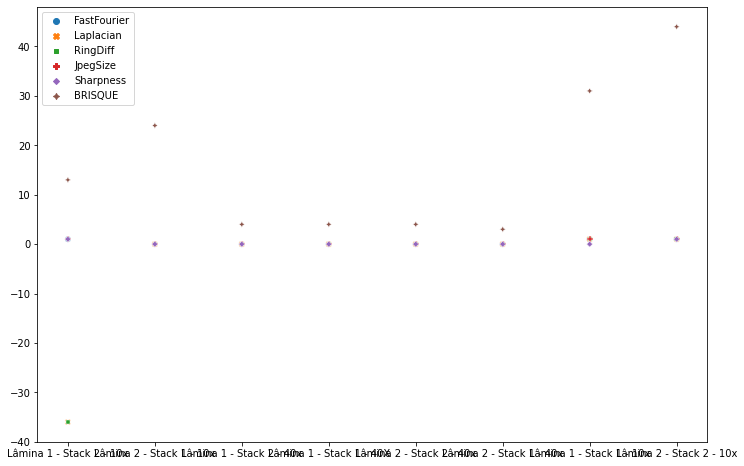

In [79]:
%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.scatterplot(data=aff_df)
# plt.show()
# plt.savefig('away_from_focus.png')

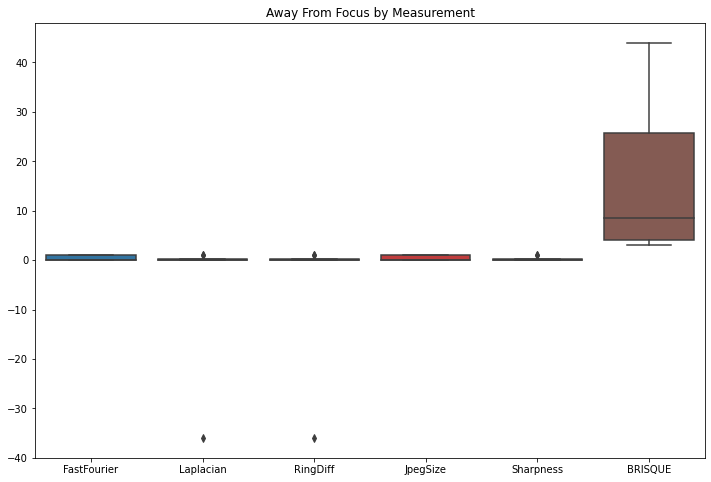

In [25]:
%matplotlib inline
plt.figure(figsize=(12, 8))
fig = sns.boxplot(data=aff_df)
plt.title("Away From Focus by Measurement")
# plt.show()
plt.savefig('away_from_focus_boxplot.png')

In [44]:
y_true = [0, 0, 0, 0, 0, 0, 0, 0]

for measurement in aff_df.columns:
    y_pred = []
    for stack in aff_df[measurement]:
        y_pred.append(stack)
    
    print("{} has a MSE of {}".format(measurement, MSE(y_true, y_pred)))

FastFourier has a MSE of 0.375
Laplacian has a MSE of 162.25
RingDiff has a MSE of 162.25
JpegSize has a MSE of 0.375
Sharpness has a MSE of 0.25
BRISQUE has a MSE of 462.375
